Comparing the quartet compatibility of the true tree vs the ASTRAL inferred tree when the quartet generation strategy is EVANS-ALL or EVANS-ONE. 

- If quartet compatibility on inferred is lower than that of true, then it could be a problem of ASTRAL not having good bipartitions.
- If quartet compatibility on inferred is higher than that of true, then there's a problem because there's nothing wrong with ASTRAL, it's the quartet generation strategy that's bad 

In [1]:
from scripts.lib.quartet_scorer import QuartetScorer
from scripts.lib.getQuartets import get_quartets

In [2]:
E_FACTOR = [1]
H_FACTOR = ["0", "0.01", "0.05", "0.2"]
C_FACTOR = [1]
POLYMORPHISM = ["high"]

TREES = 32
REPLICAS = 4
QGEN_METHODS = [11, 12]

In [3]:
e_factor, h_factor, c_factor, poly = 1, "0", 1, "mod"
tree, replica = 1, 1
qgen_method = 10 # Evans-ALL

In [4]:
from pathlib import Path 
import seaborn as sns 
import pandas as pd 
import matplotlib.pyplot as plt
import os 

In [5]:
TALLIS = Path(os.getenv("TALLIS"))
OMP = TALLIS / "OneMostProb"

In [6]:
def get_data_csv_path(
    e_factor,
    h_factor,
    c_factor,
    poly,
    tree,
    replica
):
    return OMP / "example" / "all_simulated_data" / f"{poly}_{h_factor}_{e_factor}_{c_factor}" / f"sim_tree{tree}_{replica}.csv"

In [7]:
model_trees = open(OMP / "example" / "all_simulated_data" / "trees.txt", "r").readlines()
from io import StringIO
from Bio import Phylo
def get_model_tree_newick(tree):
    assert 1 <= tree <= 32, f"{tree=}, should be between 1 and 32."
    return model_trees[tree - 1]

def get_model_tree(tree):
    nwk = get_model_tree_newick(tree)
    return Phylo.read(StringIO(nwk), format = "newick")

def get_inferred_tree(
    e_factor,
    h_factor,
    c_factor,
    poly,
    tree,
    replica,
    method,
):
    return Phylo.read(
        OMP / "sim_outputs" / f"{poly}_{h_factor}_{e_factor}_{c_factor}" / method / "trees" /  f"sim_tree{tree}_{replica}.tree",
        format = "newick"
    )

In [19]:
_, quartets = get_quartets(
    csv_path = get_data_csv_path(e_factor, h_factor, c_factor, poly, tree, replica),
    mode = qgen_method
)

In [20]:
qs = QuartetScorer(get_model_tree(tree))

In [21]:
def get_sat_score(
    quartets, 
    tree
):
    qs = QuartetScorer(tree)
    tot_quartets, sat_quartets = 0, 0
    for q, w in quartets.items():
        tot_quartets += w
        if qs.test_quartet(q):
            sat_quartets += w
    return sat_quartets, tot_quartets, sat_quartets / tot_quartets

In [22]:
def get_inf_sat_score(
        e_factor,
        h_factor,
        c_factor,
        poly,
        tree,
        replica,
        method,
):
    log_file_path = OMP / "sim_outputs" / f"{poly}_{h_factor}_{e_factor}_{c_factor}" / method / "logs" /  f"sim_tree{tree}_{replica}.log"
    with open(log_file_path, "r") as lf:
        lines = lf.readlines()
        tot_quartets = int(lines[5].split()[0])
        sat_quartets = int(lines[-4].split()[-1])
        return sat_quartets, tot_quartets, sat_quartets / tot_quartets

In [23]:
get_inf_sat_score(
        e_factor,
        h_factor,
        c_factor,
        poly,
        tree,
        replica,
        f"ASTRAL({qgen_method},5)",
)

(262133, 262430, 0.9988682696338071)

In [24]:
from itertools import product
from tqdm import tqdm
data = []
for (e_factor, h_factor, c_factor, poly, tree, replica, qgen_method) in tqdm(product(
    E_FACTOR, H_FACTOR, C_FACTOR, POLYMORPHISM, range(1, 21), [1], QGEN_METHODS
)):
    _, quartets = get_quartets(
        csv_path = get_data_csv_path(e_factor, h_factor, c_factor, poly, tree, replica),
        mode = qgen_method
    )
    _, _, model_sat = get_sat_score(quartets, get_model_tree(tree))
    _, _, inf_sat = get_inf_sat_score(
        e_factor,
        h_factor,
        c_factor,
        poly,
        tree,
        replica,
        f"ASTRAL({qgen_method},5)",
    )
    data.append((e_factor, h_factor, c_factor, poly, tree, replica, qgen_method, model_sat, inf_sat))

0it [00:00, ?it/s]

160it [28:32, 10.71s/it]


In [25]:
df = pd.DataFrame.from_records(
    data,
    columns = [
        'e_factor',
        'h_factor',
        'c_factor',
        'poly',
        'tree',
        'replica',
        'qgen_method',
        'model_sat',
        'inf_sat'
    ]
)

In [40]:
df['qgen_method_text'] = df['qgen_method'].map(
    lambda x: "EVANS-ALL-K" if x == 11 else "EVANS-ONE-K"
)
df['model_sat'] /= 100
df['inf_sat'] /= 100

In [41]:
df.to_csv(OMP / "inferred_vs_true_quartet.csv")

In [8]:
df = pd.read_csv(OMP / "inferred_vs_true_quartet.csv")

In [9]:
df.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,e_factor,h_factor,c_factor,poly,tree,replica,qgen_method,model_sat,inf_sat,qgen_method_text,sat_diff
0,0,0,0,1,0.0,1,high,1,1,11,99.637738,99.660153,EVANS-ALL-K,2.241473
1,1,1,1,1,0.0,1,high,1,1,12,98.869699,99.185867,EVANS-ONE-K,31.616804
2,2,2,2,1,0.0,1,high,2,1,11,99.967376,99.967376,EVANS-ALL-K,0.000000
3,3,3,3,1,0.0,1,high,2,1,12,99.806683,99.806683,EVANS-ONE-K,0.000000
4,4,4,4,1,0.0,1,high,3,1,11,99.858643,99.886444,EVANS-ALL-K,2.780160


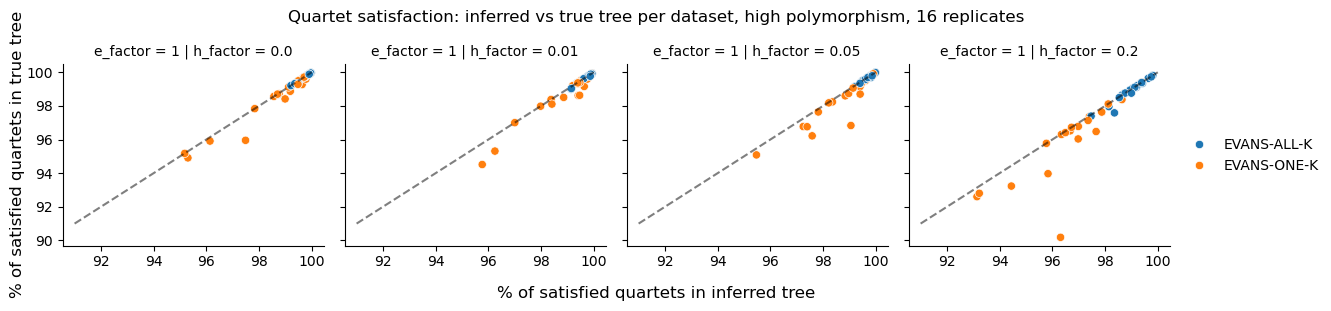

In [10]:
# def plot_wrt_c_h(c_factor, h_factor):
g = sns.FacetGrid(
    data = df,
    row = 'e_factor',
    col = 'h_factor'
)
llim = 91
g.map(
    sns.lineplot,
    x = [llim, 100],
    y = [llim, 100],
    linestyle='--',
    color='black',
    alpha=.5
)
g.map_dataframe(
    sns.scatterplot,
    y = 'model_sat',
    x = 'inf_sat',
    hue = 'qgen_method_text'
)
g.tight_layout()
g.set_xlabels("")
g.set_ylabels("")
g.figure.supxlabel("% of satisfied quartets in inferred tree")
g.figure.supylabel("% of satisfied quartets in true tree")
g.figure.subplots_adjust(top=0.8)
g.figure.suptitle("Quartet satisfaction: inferred vs true tree per dataset, high polymorphism, 16 replicates", wrap=True)
g.add_legend()
g.savefig(OMP / "figs" / "qs-inferred-vs-true.png")

In [11]:
df

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,e_factor,h_factor,c_factor,poly,tree,replica,qgen_method,model_sat,inf_sat,qgen_method_text,sat_diff
0,0,0,0,1,0.0,1,high,1,1,11,99.637738,99.660153,EVANS-ALL-K,2.241473
1,1,1,1,1,0.0,1,high,1,1,12,98.869699,99.185867,EVANS-ONE-K,31.616804
2,2,2,2,1,0.0,1,high,2,1,11,99.967376,99.967376,EVANS-ALL-K,0.000000
3,3,3,3,1,0.0,1,high,2,1,12,99.806683,99.806683,EVANS-ONE-K,0.000000
4,4,4,4,1,0.0,1,high,3,1,11,99.858643,99.886444,EVANS-ALL-K,2.780160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,155,155,155,1,0.2,1,high,18,1,12,97.131924,97.355460,EVANS-ONE-K,22.353565
156,156,156,156,1,0.2,1,high,19,1,11,99.388419,99.388937,EVANS-ALL-K,0.051785
157,157,157,157,1,0.2,1,high,19,1,12,98.112258,98.120648,EVANS-ONE-K,0.838997
158,158,158,158,1,0.2,1,high,20,1,11,98.758633,98.997835,EVANS-ALL-K,23.920216


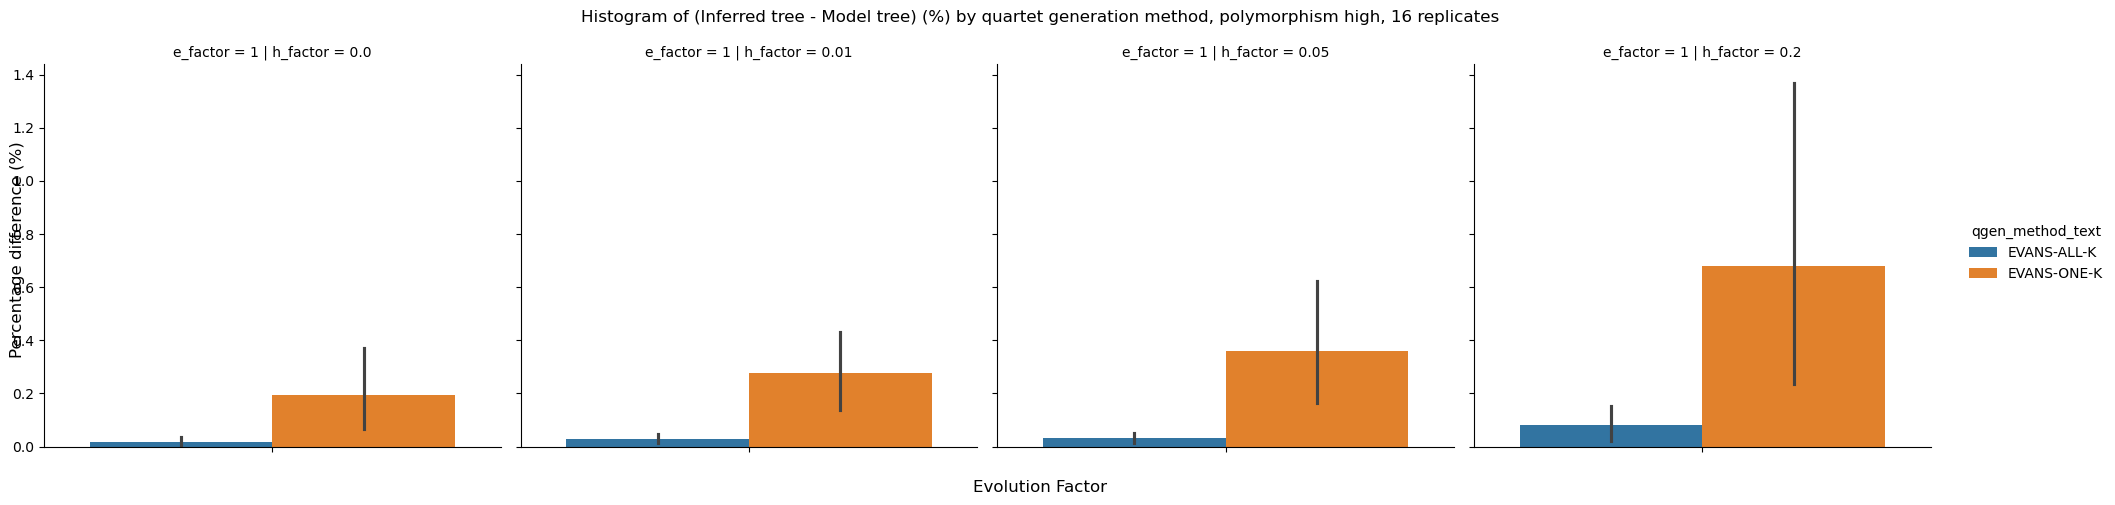

In [21]:
# def plot_wrt_c_h(c_factor, h_factor):
df['sat_diff'] = df['inf_sat'] - df['model_sat']

g2 = sns.catplot(
    data = df,
    row = 'e_factor',
    col = 'h_factor',
    y = 'sat_diff',
    hue = 'qgen_method_text',
    kind='bar',
    # element= 'poly'
)
# g2.tight_layout()
g2.set_xlabels("")
g2.set_ylabels("")
g2.figure.subplots_adjust(top=0.9, right=1.5)
g2.figure.supxlabel("Evolution Factor")
g2.figure.supylabel("Percentage difference (%)")
g2.figure.suptitle("Histogram of (Inferred tree - Model tree) (%) by quartet generation method, polymorphism high, 16 replicates", wrap=True)
g2.tight_layout()
g.savefig(OMP / "figs" / "qs-inferred-diff-true.png")